I have hit compare
I have hit compare


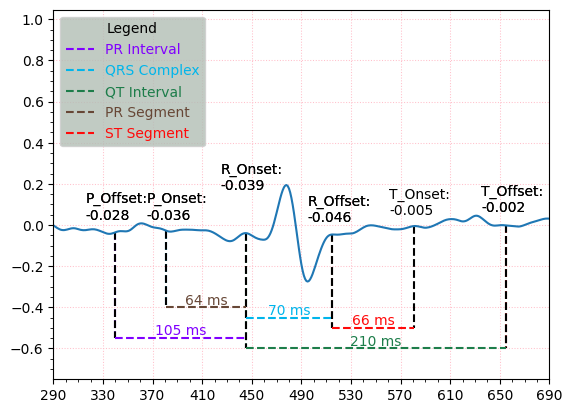

<Figure size 640x480 with 0 Axes>

In [1]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import matplotlib.ticker as ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import argparse

RATE = 500
FILE = "./ECGS/data-0.npy"
ROUNDING_DIGITS = 3

def plotting(ypos, left, right, color):
    plt.hlines(y=ypos, xmin=left, xmax=right, color=color, linestyle='--')
    interval = right - left
    intcenter = (left + right) / 2

    plt.text(intcenter, ypos, f'{interval} ms', ha='center', va='bottom', color=color)


def vplotter(filtered_signal, x, y, text=None, value=None, color='black'):
    plt.plot([x, x], [filtered_signal[x], y], color, linestyle='--', )
    #plt.plot([x, x], [filtered_signal[x], y], "black", linestyle='--', )

    # two for loops for forward and back checking finding highest height in the region
    new_y = filtered_signal[x]
    for i in range(30):
        if filtered_signal[x + i] > new_y:
            new_y = filtered_signal[x + i]
    for i in range(30):
        if filtered_signal[x - i] > new_y:
            new_y = filtered_signal[x - i]

    if text==str("P_Onset"): 
        x+=45
        print("I have hit compare")
    if text ==str("P_Offset"):
        x-=45

    if text is not None:
        plt.text(x - 20, new_y + 0.02, str(text) + ":\n" + str(value), fontsize=10)


def innerVals(vallist, checkVal, tooFar, tooClose):
#     print (checkVal)
    if checkVal is None:
        return -2
    for val in vallist:
#         print("trying val", val)
        if (math.isnan(val)):
#             print("nan found")
            continue
        if (val < checkVal):
#             print("too low")
            continue
        if (val - checkVal > tooFar):
#             print("too far")
            return -1
        if (val - checkVal < tooClose):
#             print("oops,", val, "is too close, move to the next value")
            continue
        if (val - checkVal <= tooFar):
            return val

        #P Values are incorrectly labeled the majority of the time, in light of this, feature extraction will try to continue without them
def badP():
#     print("BADP HAS BEEN CALLED")
    rOff = -2
    tOn = -2
    tOff = -2
    for rOn in rlist[0]:
        if math.isnan(rOn):
            continue
#         print("Using rOn", rOn)
        
        rOff = innerVals(rlist[2], rOn, 300, 0)
        if (rOff == -1):
            continue
        if (rOff is None):
            return [-1]
#         print("Using rOff", rOff)
        tOn = innerVals(tlist[0], rOff, 200, 0)
        if (tOn == -1):
            continue
        if (tOn is None):
            return [-1]
#         print("Using tOn", tOn)
        tOff = innerVals(tlist[2], tOn, 200, 0)
        if (tOff == -1):
            continue
        if (tOff is None):
            return [-1]
#         print("Using tOff", tOff)
        break
    #Failsafe
    if (tOn == -2 or tOff == -2 or rOff == None or tOn == None or tOff == None):
        return [-1]
    else:
        masterList = [rOn, rOff, tOn, tOff, 2]
        return masterList

def setVals():
    pOff = -2
    rOn = -2
    rOff = -2
    tOn = -2
    tOff = -2
    
    #Go through P_Onset list
    for pOn in plist[0]:
        if math.isnan(pOn):
            continue
#         print("Using pOn", pOn)
        
        #Get value from P_Offset list that is between 0 and 200 units away from current P_Onset value
        pOff = innerVals(plist[2], pOn, 100, 0)
        
        #If one is not found, move to next P_Onset value
        if (pOff == -1):
            continue
        
        #If one is not found in the entire list, throw out P values entirely by calling badP()
        if (pOn == plist[0][-1]):
            return badP()
#         print("Using pOff", pOff)
        
        #Get value from R_Onset list that is between 0 and 200 units away from valid P_Offset value
        rOn = innerVals(rlist[0], pOff, 100, 0)
        
        #If one is not found, move to next P_Onset value
        if (rOn == -1):
            continue
        
        #If one is not found in the entire list, throw out P values entirely by calling badP()
        if (pOn == plist[0][-1]):
            return badP()
#         print("Using rOn", pOff)
        
        #Get value from R_Offset list that is between 0 and 300 units away from valid R_Onfset value
        rOff = innerVals(rlist[2], rOn, 300, 0)
        
        #If one is not found, move to next P_Onset value
        if (rOff == -1):
            continue
            
        #If one is not found in the entire list, the entire extraction has failed, and the failsafe must trigger
        if (rOff is None):
            return [-1]
#         print("Using rOff", rOff)
        
        #Get value from T_Onset list that is between 0 and 200 units away from valid R_Offset value
        tOn = innerVals(tlist[0], rOff, 200, 0)
        
        #If one is not found, move to next P_Onset value
        if (tOn == -1):
            continue
        if (tOn is None):
            return [-1]
#         print("Using tOn", tOn)
        
        #Get value from T_Offset list that is between 0 and 200 units away from valid T_Onset value
        tOff = innerVals(tlist[2], tOn, 200, 0)
        
        #If one is not found, move to next P_Onset value
        if (tOff == -1):
            continue
        if (tOff == -2):
            return [-1]
#         print("Using tOff", tOff)
        break
        
    #Failsafe
    if (rOn == -2 or rOn == -2 or tOn == -2 or tOff == -2 or pOff == -2 or rOn == None or rOff == None or tOn == None or tOff == None or pOff == None):
        return [-1]
    else:
        masterList = [pOn, pOff, rOn, rOff, tOn, tOff, 1]
        return masterList


    
def worked():
    # Plot the signal
    
    #PR Legend Line Coloring
    vplotter(filtered_signal, masterList[0], -0.55, 'P_Onset', round(filtered_signal[masterList[0]], ROUNDING_DIGITS), "#8000FF")  # Graphs the p_onset down to the PR interval
    #QRS Legend Line Plotting
    vplotter(filtered_signal, masterList[1], -0.4, 'P_Offset', round(filtered_signal[masterList[1]], ROUNDING_DIGITS), "#00B5EB")  # Graphs the p_offset down to the PR inteval
    #QT Legend Line Coloring
    vplotter(filtered_signal, masterList[2], -0.6, 'R_Onset', round(filtered_signal[masterList[2]], ROUNDING_DIGITS), "#1d7d4a")  # Graphs the r_onset down to the QT interval level
    #PR Segment Coloring
    vplotter(filtered_signal, masterList[3], -0.5, 'R_Offset', round(filtered_signal[masterList[3]], ROUNDING_DIGITS), "#674736")  # Graphs the r_offset down to ST interval
    #ST Segment Coloring
    vplotter(filtered_signal, masterList[5], -0.6, 'T_Offset', round(filtered_signal[masterList[5]], ROUNDING_DIGITS), "#FF0A0A")  # Graphs the t_offset down to the QT interval level



    vplotter(filtered_signal, masterList[2], -0.6, 'R_Onset', round(filtered_signal[masterList[2]], ROUNDING_DIGITS))  # Graphs the r_onset down to the QT interval level
    vplotter(filtered_signal, masterList[5], -0.6, 'T_Offset', round(filtered_signal[masterList[5]], ROUNDING_DIGITS))  # Graphs the t_offset down to the QT interval level
    vplotter(filtered_signal, masterList[3], -0.5, 'R_Offset', round(filtered_signal[masterList[3]], ROUNDING_DIGITS))  # Graphs the r_offset down to ST interval
    vplotter(filtered_signal, masterList[4], -0.5, 'T_Onset', round(filtered_signal[masterList[4]], ROUNDING_DIGITS))  # Graphs the t_onset down to the QT interval level
    vplotter(filtered_signal, masterList[0], -0.55, 'P_Onset', round(filtered_signal[masterList[0]], ROUNDING_DIGITS))  # Graphs the p_onset down to the PR interval
    vplotter(filtered_signal, masterList[1], -0.4, 'P_Offset', round(filtered_signal[masterList[1]], ROUNDING_DIGITS))  # Graphs the p_offset down to the PR inteval

    
    plotting(-.55, masterList[0], masterList[2], '#8000FF')  # PR Interval pOn - rOn
    plotting(-.45, masterList[2], masterList[3], '#00B5EB')  # QRS Complex rOn - rOff
    plotting(-.4, masterList[1], masterList[2], '#674736')  # PR Segment  pOff - rOn
    plotting(-.6, masterList[2], masterList[5], '#1d7d4a')  # QT Interval rOn - tOff
    plotting(-.5, masterList[3], masterList[4], '#FF0A0A')  # ST Segment  rOff - tOn

    colorlist = ['#8000FF', '#00B5EB', '#1d7d4a', '#674736', '#FF0A0A']

    legend = plt.legend(["PR Interval", "QRS Complex", "QT Interval", "PR Segment", "ST Segment"], facecolor='#b2beb5',
                        title="Legend", labelcolor=colorlist, loc='upper left')


    plt.plot(filtered_signal)

    # Visualize waves in ECG signal
    plt.xlim(masterList[0] - 50, masterList[1] + 50)
    plt.ylim(-.75, filtered_signal[max(rlist[1])]+.8)
    # plt.ylim(filtered_signal[masterList[1]], filtered_signal[masterList[0]])

    

    
    #legend.get_title().set_backgroundcolor('gray')

    # Used to create the small and large grid lines
    plt.xticks(range(masterList[0] - 50, masterList[5] + 50, 40))  # Changes the x-axis, is vital to things working. Changes graph slightly not sure exactly how but the scaling of the x_label is slightly controlled
    plt.minorticks_on()  # Required for the smaller boxes to be created

    plt.grid(True, which='major', color='pink', axis='both', linestyle=':', linewidth=0.75)
    plt.show()
    
def pFailed():
    # Plot the signal
    
    #Colors the QRS Legend Line
    vplotter(filtered_signal, masterList[0], -0.6, 'R_Onset', round(filtered_signal[masterList[0]], ROUNDING_DIGITS), "#00B5EB")  # Graphs the r_onset down to the QT interval level
    #Colors the QT Legend Line
    vplotter(filtered_signal, masterList[1], -0.5, 'R_Offset', round(filtered_signal[masterList[1]], ROUNDING_DIGITS),"#1d7d4a")  # Graphs the r_offset down to ST interval
    #Colors the ST Legend Line
    vplotter(filtered_signal, masterList[2], -0.5, 'T_Onset', round(filtered_signal[masterList[2]], ROUNDING_DIGITS), "#FF0A0A")  # Graphs the t_onset down to the QT segment level



    vplotter(filtered_signal, masterList[0], -0.6, 'R_Onset', round(filtered_signal[masterList[0]], ROUNDING_DIGITS))  # Graphs the r_onset down to the QT interval level
    vplotter(filtered_signal, masterList[3], -0.6, 'T_Offset', round(filtered_signal[masterList[3]], ROUNDING_DIGITS))  # Graphs the t_offset down to the QT interval level
    vplotter(filtered_signal, masterList[1], -0.5, 'R_Offset', round(filtered_signal[masterList[1]], ROUNDING_DIGITS))  # Graphs the r_offset down to ST interval
    vplotter(filtered_signal, masterList[2], -0.5, 'T_Onset', round(filtered_signal[masterList[2]], ROUNDING_DIGITS))  # Graphs the t_onset down to the QT segment level
    
    plotting(-.4, masterList[0], masterList[1], '#00B5EB')  # QRS Complex rOn - rOff
    plotting(-.6, masterList[0], masterList[3], '#1d7d4a')  # QT Interval rOn - tOff
    plotting(-.5, masterList[1], masterList[2], '#FF0A0A')  # ST Segment  rOff - tOn



    colorlist = [ '#00B5EB', '#1d7d4a', '#FF0A0A']

    legend = plt.legend(["QRS Complex", "QT Interval", "ST Segment"], facecolor='lightgray',
                        title="Legend", labelcolor=colorlist, loc='upper right')

    # Visualize waves in ECG signal
    plt.xlim(masterList[0] - 50, masterList[3] + 50)
    plt.ylim(-.75, filtered_signal[max(rlist[1])]+.8)
    # plt.ylim(filtered_signal[masterList[1]], filtered_signal[masterList[0]])

    plt.plot(filtered_signal)


    legend.get_title().set_backgroundcolor('gray')

    # Used to create the small and large grid lines
    plt.xticks(range(masterList[0] - 50, masterList[3] + 50, 40))  # Changes the x-axis, is vital to things working. Changes graph slightly not sure exactly how but the scaling of the x_label is slightly controlled
    plt.minorticks_on()  # Required for the smaller boxes to be created

    plt.grid(True, which='major', color='pink', axis='both', linestyle=':', linewidth=0.75)
    plt.show()
    
def failsafe():
    plt.plot(filtered_signal[300:1300])
    plt.minorticks_on()  # Required for the smaller boxes to be created
    plt.grid(True, which='major', color='pink', axis='both', linestyle='--', linewidth=0.75)
    plt.grid(True, which='minor', color='blue', axis='both', linestyle=':', linewidth=0.25)
    
# Get args
# parser = argparse.ArgumentParser(description='Load an ECG dataset')
# parser.add_argument('ecg_file', metavar='FILE', type=str,
#                     help='the path to the ECG file to load')
# args = parser.parse_args()

# Load file from args, extract Lead II
# ecg1 = np.load(args.ecg_file)
ecg1 = np.load(FILE)
ecg1 = np.concatenate(ecg1, axis=0)
lead_II = []

for i in range(0, 5000):
    lead_II.append(ecg1[i][1])
lead_II = np.asarray(lead_II)

# FILTERS OUR LEAD II
import scipy

# Define the bandpass filter parameters
lowcut = 0.5  # Hz
highcut = 20  # Hz
fs = 500  # Hz
order = 4

# Design the filter
b, a = scipy.signal.butter(order, [lowcut, highcut], btype='bandpass', fs=fs)

# Apply the filter to the signal
filtered_signal = scipy.signal.lfilter(b, a, lead_II)

# Get R-Peaks from signal
_, rwaves = nk.ecg_peaks(filtered_signal, sampling_rate=RATE)

# Delineate the ECG signal, getting other peak types, offsets, and onsets
_, waves_peak = nk.ecg_delineate(filtered_signal, rwaves, sampling_rate=RATE, method="cwt", show=False, show_type="all")

rvals = rwaves['ECG_R_Peaks']

# Get lists of Onsets, Peaks, and Offsets per type
plist = []
plist.append(waves_peak['ECG_P_Onsets'])
plist.append(waves_peak['ECG_P_Peaks'])
plist.append(waves_peak['ECG_P_Offsets'])

rlist = []
rlist.append(waves_peak['ECG_R_Onsets'])
rlist.append(rwaves['ECG_R_Peaks'])
rlist.append(waves_peak['ECG_R_Offsets'])

qlist = []
qlist.append(waves_peak['ECG_Q_Peaks'])

slist = []
slist.append(waves_peak['ECG_S_Peaks'])

tlist = []
tlist.append(waves_peak['ECG_T_Onsets'])
tlist.append(waves_peak['ECG_T_Peaks'])
tlist.append(waves_peak['ECG_T_Offsets'])

# Create list of valid values to use for intervals
masterList = setVals()

if masterList[-1] == 1:
    worked()
elif masterList [-1] == 2:
    pFailed()
else:
    failsafe()

plt.savefig("./figs/main.png")



In [2]:
waves_peak

{'ECG_P_Onsets': [340,
  664,
  847,
  1178,
  nan,
  1684,
  nan,
  2186,
  2446,
  2719,
  2961,
  3318,
  3498,
  3696,
  3966,
  4252,
  4442,
  4692],
 'ECG_P_Peaks': [361,
  688,
  869,
  1210,
  1292,
  1695,
  1957,
  2207,
  2476,
  2740,
  3004,
  3356,
  3533,
  3713,
  4008,
  4290,
  4477,
  4710],
 'ECG_P_Offsets': [381,
  700,
  nan,
  nan,
  1314,
  1711,
  1972,
  2231,
  2489,
  2762,
  3032,
  nan,
  3554,
  3730,
  4019,
  4309,
  4509,
  4731],
 'ECG_Q_Peaks': [216,
  460,
  707,
  959,
  1232,
  nan,
  1789,
  2069,
  2332,
  2544,
  2834,
  3113,
  3370,
  3576,
  3822,
  4051,
  4323,
  4552,
  nan],
 'ECG_R_Onsets': [203,
  445,
  723,
  945,
  1210,
  1490,
  1777,
  2056,
  2306,
  nan,
  2817,
  3091,
  3356,
  3563,
  nan,
  4036,
  4307,
  4566,
  4817],
 'ECG_R_Offsets': [280,
  515,
  780,
  1014,
  1292,
  1559,
  1853,
  2124,
  2389,
  2620,
  2904,
  3169,
  3443,
  3631,
  3901,
  4116,
  4392,
  4634,
  4893],
 'ECG_S_Peaks': [263,
  496,
  762,
  

In [3]:
masterList

[340, 381, 445, 515, 581, 655, 1]